# Testing notebook for work carried out by George 

Owner: George Hine

email: ppygh3@nottingham.ac.uk

Set path and Imports:

In [1]:
import sys
sys.path.append('..')

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [3]:
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax.gax_fits as gfits
from astropy.io import fits

bands = np.array(['u','g','r','i','z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



Import extracted arms

In [4]:
# Now wish to make composite from arm isolated images to display in RGB
u = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ua/0135/small_nonpar.fits')

g = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ga/0200/small_nonpar.fits')

r = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ra/0200/small_nonpar.fits')

i = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ia/0188/small_nonpar.fits')

z = gfits.Read('/home/borge/Data/Output_Data/588017724937142430za/0200/small_nonpar.fits')

Composite_isolated = np.stack([u,g,r,i,z],axis=2)


In [5]:
Composite_isolated.shape


(400, 232, 5)

In [6]:
Composite = gfits.Read_M_band('588017724937142430','/home/borge/Data/Test_fits/')

['/home/borge/Data/Test_fits/588017724937142430ua.fits.gz']
['/home/borge/Data/Test_fits/588017724937142430ga.fits.gz']
['/home/borge/Data/Test_fits/588017724937142430ra.fits.gz']
['/home/borge/Data/Test_fits/588017724937142430ia.fits.gz']
['/home/borge/Data/Test_fits/588017724937142430za.fits.gz']


In [7]:
Composite_profiles = Composite - Composite_isolated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


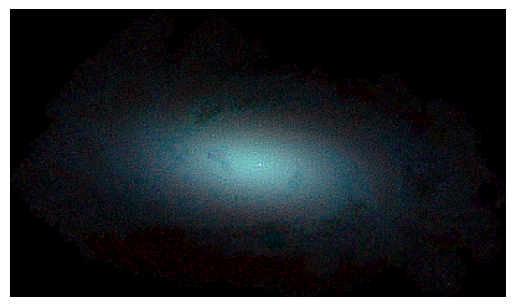

In [8]:
gfits.multi_band_imshow(Composite_profiles,4,2,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


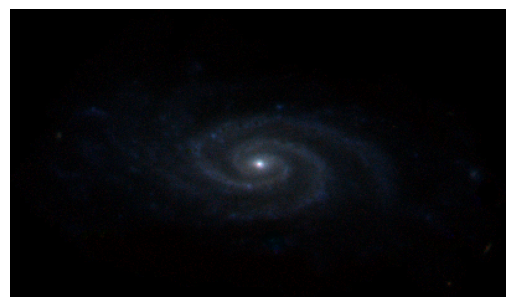

In [9]:
gfits.multi_band_imshow(Composite,4,2,1)

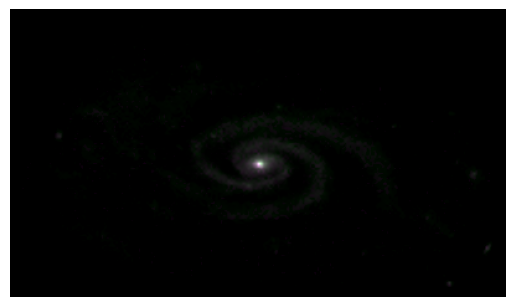

In [10]:
gfits.multi_band_imshow(Composite_isolated,4,3,4)

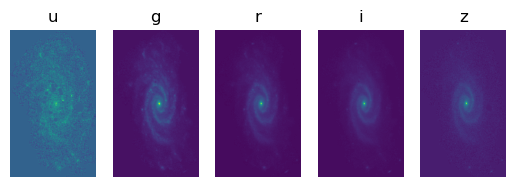

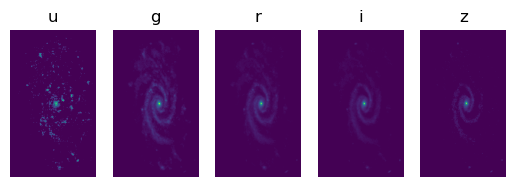

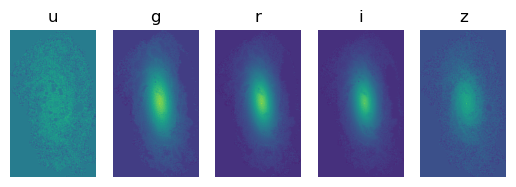

In [11]:
def Composite_imshow(Composite):
    
    fig, ax = plt.subplots(1,5)
    
    for i in range(0,len(bands)):
        ax[i].imshow(Composite[:,:,i])
        ax[i].set_title('{}'.format(bands[i]))
        ax[i].axis('off')

Composite_imshow(Composite)
    

Composite_imshow(Composite_isolated)
    

Composite_imshow(Composite_profiles)
    


looks good so will now transfer to gfits

Text(0.5, 0.98, 'Profiles')

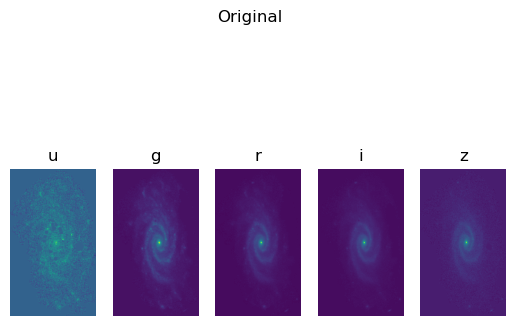

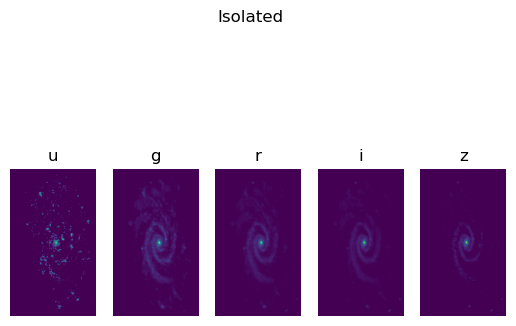

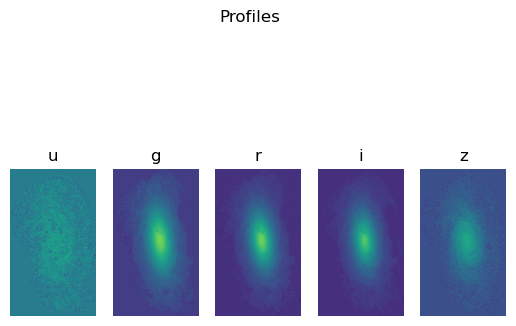

In [12]:

gfits.Composite_imshow(Composite)
plt.suptitle('Original')
    
gfits.Composite_imshow(Composite_isolated)
plt.suptitle('Isolated')

gfits.Composite_imshow(Composite_profiles)
plt.suptitle('Profiles')
    

In [13]:
Composite_centroids = np.empty((2,Composite.shape[2])) 
for i in range(0,Composite.shape[2]):
    x,y = gfits.centroid(Composite[:,:,i],cartesian=False)
    Composite_centroids[0:i] = x
    Composite_centroids[1:i] = y
        


In [14]:
Composite_centroids

array([[115.53492266, 115.53492266, 115.53492266, 115.53492266,
        115.53492266],
       [199.49269852, 199.49269852, 199.49269852, 199.49269852,
        199.49269852]])

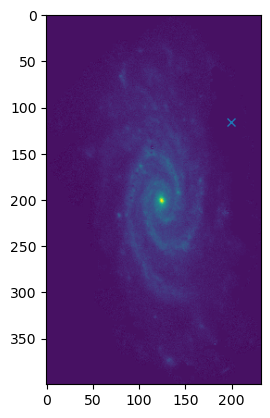

In [15]:
# Want to plot centroid on image to check:
plt.figure()
plt.imshow(Composite[:,:,1])
plt.plot(Composite_centroids[1,1],Composite_centroids[0,1],'x')

# Close enough

In [16]:
print('x: ',Composite_centroids[1,1],'y: ',Composite_centroids[0,1])

x:  199.4926985217898 y:  115.53492265826799


Have been reading about 2dfft as a way to determine number of arms.

Wish to write a function to do this and wonder if there is any automated way to do this i.e if there is some automated way of noting irregularities.

Requires research.

will first write the code:

In [17]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from skimage import io

# First need to power spectrum the image and have a look

# Then need a way of summing within a radius - will try with masks

2.8316318707480983 36.71451686324379
13.91241747887851


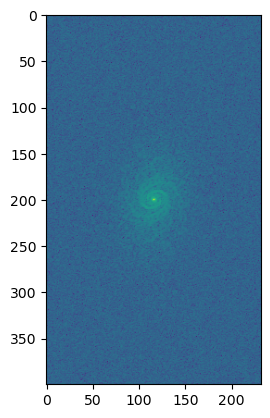

In [18]:
Image = Composite[:,:,1]



img_fft = fftshift(fft2(Image))
power_spectrum = np.abs(img_fft**2)
plt.figure()
plt.imshow(np.log(power_spectrum))
#crop_l = Image.shape[0]/2
#crop_h = Image.shape[1]/2
#l =40
#h =40
#plt.xlim(crop_l-l,crop_l+l)
#plt.ylim(crop_h-h,crop_h+h)

#A = 10
#plt.clim(np.mean(power_spectrum)-A*np.std(power_spectrum),np.mean(power_spectrum)+A*np.std(power_spectrum))
#print(np.min(img_fft),np.max(img_fft))
print(np.min(np.log(power_spectrum)),np.max(np.log(power_spectrum)))
print(np.mean(np.log(power_spectrum)))





In [19]:
def circle_mask(shape, center, radius):
    # Create a 2D grid of coordinates with the specified shape
    y, x = np.ogrid[:shape[0], :shape[1]]
    # Calculate the distance from each point to the center
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    # Create a boolean mask based on the distance and the radius
    mask = dist <= radius
    return mask

#Image_shape = Image.shape
center = gfits.centroid(np.log(power_spectrum),cartesian=False)
radius = np.sqrt((Image.shape[0]/2)**2 +(Image.shape[1]/2)**2)
mask = circle_mask(Image.shape,center,0.99*radius)

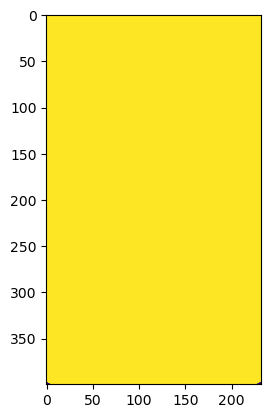

In [20]:
plt.imshow(mask)

[  0.           2.33540946   4.67081891   7.00622837   9.34163783
  11.67704729  14.01245674  16.3478662   18.68327566  21.01868512
  23.35409457  25.68950403  28.02491349  30.36032294  32.6957324
  35.03114186  37.36655132  39.70196077  42.03737023  44.37277969
  46.70818914  49.0435986   51.37900806  53.71441752  56.04982697
  58.38523643  60.72064589  63.05605535  65.3914648   67.72687426
  70.06228372  72.39769317  74.73310263  77.06851209  79.40392155
  81.739331    84.07474046  86.41014992  88.74555937  91.08096883
  93.41637829  95.75178775  98.0871972  100.42260666 102.75801612
 105.09342558 107.42883503 109.76424449 112.09965395 114.4350634
 116.77047286 119.10588232 121.44129178 123.77670123 126.11211069
 128.44752015 130.7829296  133.11833906 135.45374852 137.78915798
 140.12456743 142.45997689 144.79538635 147.13079581 149.46620526
 151.80161472 154.13702418 156.47243363 158.80784309 161.14325255
 163.47866201 165.81407146 168.14948092 170.48489038 172.82029984
 175.1557092

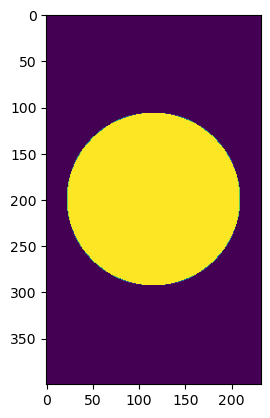

In [21]:
# now want to vary the radius from 0 to max value
radius_arr = np.linspace(0,radius,100)
print(radius_arr)
mask_arr = np.empty((Image.shape[0],Image.shape[1],len(radius_arr)))

for i in range(0,len(radius_arr)):
    mask_arr[:,:,i] = circle_mask(Image.shape,center,radius_arr[i])
    
plt.imshow(mask_arr[:,:,40])

In [22]:
# now need to apply masks to image and sum

image_masked_sum = np.empty_like(radius_arr)
for i in range(0,len(radius_arr)):
    image_masked_sum[i] = np.sum(Image*mask_arr[:,:,i])

In [23]:
radial_bin_value = image_masked_sum - np.roll(image_masked_sum, 1)

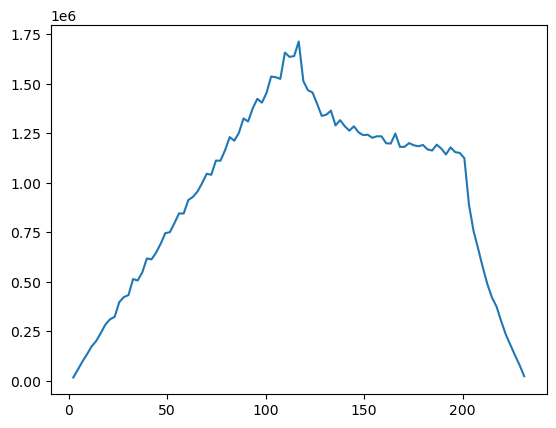

In [24]:
plt.plot(radius_arr[1:len(radius_arr)],radial_bin_value[1:len(radial_bin_value)])

In [25]:
# Now want to combine these into one function:

    
def centroid(img,cartesian):
    """First moment of the flux distribution.

    Parameters
    ----------
    img : numpy or jax array

    Returns
    -------
    x, y : floats
        The calculated centroid position.
    """
    x_cen = (np.arange(img.shape[0]) * img.sum(1) / img.sum()).sum()
    y_cen = (np.arange(img.shape[1]) * img.sum(0) / img.sum()).sum()
    
    if cartesian == True:
        return x_cen, y_cen
    else:
        return y_cen, x_cen # array indices are swapped

def circle_mask(shape, center, radius):
    # Create a 2D grid of coordinates with the specified shape
    y, x = np.ogrid[:shape[0], :shape[1]]
    # Calculate the distance from each point to the center
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    # Create a boolean mask based on the distance and the radius
    mask = dist <= radius
    return mask

def create_radial_masks(radius,center,step):
    
    radius_arr = np.linspace(0,radius,step)
    mask_arr = np.empty((Image.shape[0],Image.shape[1],len(radius_arr)))

    for i in range(0,len(radius_arr)):
        mask_arr[:,:,i] = circle_mask(Image.shape,center,radius_arr[i])
    return mask_arr

def P_max_vs_Radius(Image):
    
    img_fft = fftshift(fft2(Image))
    power_spectrum = np.log(np.abs(img_fft**2))
    
    center = centroid(np.log(power_spectrum),cartesian=False)
    radius = np.sqrt((Image.shape[0]/2)**2 +(Image.shape[1]/2)**2)  
    step = round(radius)
    
    create_radial_masks(radius,center,step)
    
    image_masked_sum = np.empty_like(radius_arr)
    for i in range(0,len(radius_arr)-1):
        image_masked_sum[i] = np.max(Image*(mask_arr[:,:,i+1]-mask_arr[:,:,i]))
        
    radial_bin_value = image_masked_sum - np.roll(image_masked_sum, 1)
    r = radius_arr[1:len(radius_arr)-1]
    p_max = radial_bin_value[1:len(radial_bin_value)-1]
    
    return r, p_max

# This function might be usefull for summing radially as well?
def sum_P_vs_Radius(Image):
    
    img_fft = fftshift(fft2(Image))
    power_spectrum = np.log(np.abs(img_fft**2))
    
    center = centroid(np.log(power_spectrum),cartesian=False)
    radius = np.sqrt((Image.shape[0]/2)**2 +(Image.shape[1]/2)**2)  
    step = round(radius)
    
    create_radial_masks(radius,center,step)
    
    image_masked_sum = np.empty_like(radius_arr)
    for i in range(0,len(radius_arr)-1):
        image_masked_sum[i] = np.sum(Image*(mask_arr[:,:,i]))
        
    radial_bin_value = image_masked_sum - np.roll(image_masked_sum, 1)
    r = radius_arr[1:len(radius_arr)-1]
    p_max = radial_bin_value[1:len(radial_bin_value)-1]
    
    return r, p_max


Text(0, 0.5, 'log(p_max)')

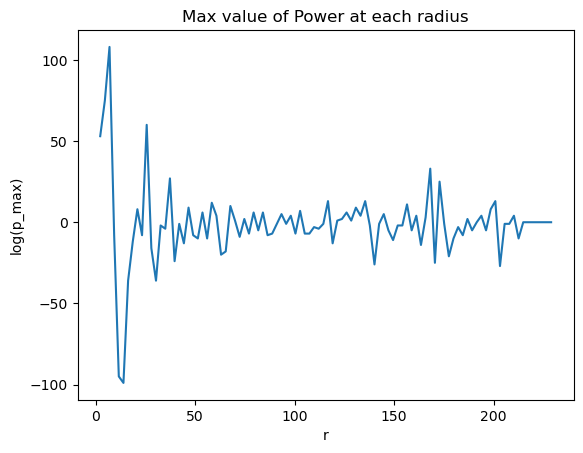

In [26]:
r,p_max = P_max_vs_Radius(Image)
plt.plot(r,p_max)
plt.title('Max value of Power at each radius')
plt.xlabel('r')
plt.ylabel('log(p_max)')

Text(0, 0.5, 'log(p_max)')

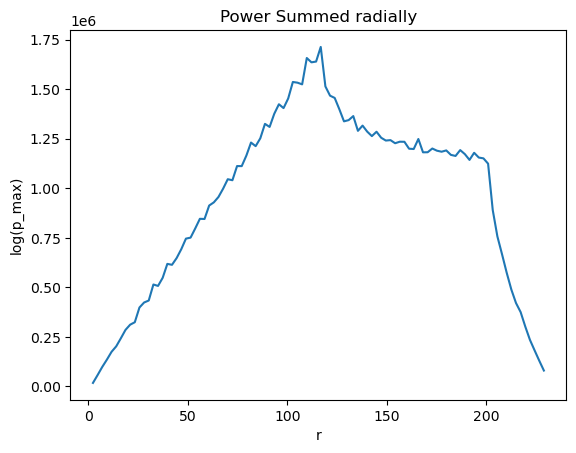

In [27]:
r,p_sum = sum_P_vs_Radius(Image)
plt.plot(r,p_sum)
plt.title('Power Summed radially')
plt.xlabel('r')
plt.ylabel('log(p_max)')

Not sure if these are right

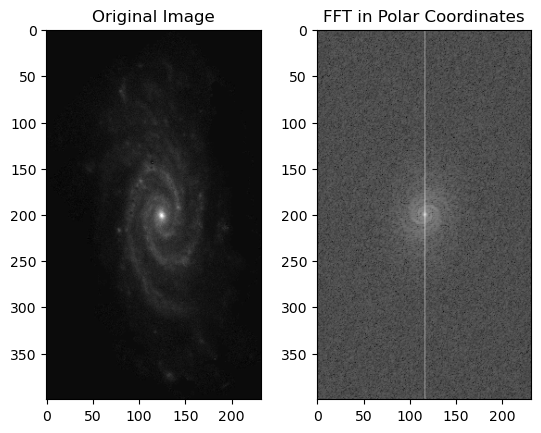

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# read the image and convert to grayscale
img = Image

# create a grid of polar coordinates
r, theta = np.meshgrid(np.linspace(0, 1, img.shape[0]), np.linspace(0, 2*np.pi, img.shape[1]), indexing='ij')

# convert to Cartesian coordinates
x = r * np.cos(theta)
y = r * np.sin(theta)

# apply the 2D FFT in polar coordinates
img_fft = fftshift(np.fft.fft2(img * r) / img.size)

# plot the original image and its FFT
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(np.log(np.abs(img_fft**2)), cmap='gray')

axs[1].set_title('FFT in Polar Coordinates')
plt.show()


In [29]:
gfits.Generate_config(filename='588017724937142430ia.fits.gz',location='/home/borge/Data/Test_fits/',config_path='/home/borge/Data/Config_files',output_path='/home/borge/Data/Output_Data/588017724937142430ia')

config_file_created: 588017724937142430ia_config.yml in /home/borge/Data/Config_files


'588017724937142430ia_config.yml'

Testing Chat GPT's ability with 'SFT'

In [30]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.optimize import basinhopping

def objective(phi, x, N2, r0):
    spiral_basis = spiral(N2, r0, phi)
    X = np.zeros(N2, dtype=np.complex128)
    for k in range(N2):
        X[k] = np.dot(x, np.conj(np.roll(spiral_basis, k)))
    return -np.abs(X).sum()

def SFT(img, r0, niter=10):
    M, N = img.shape
    x = img.flatten()
    N2 = len(x)
    res = basinhopping(objective, x0=0.1, niter=niter, minimizer_kwargs={"args": (x, N2, r0), "bounds": [(-np.pi/2, np.pi/2)]})
    phi = res.x
    spiral_basis = spiral(N2, r0, phi)
    X = np.zeros(N2, dtype=np.complex128)
    for k in range(N2):
        X[k] = np.dot(x, np.conj(np.roll(spiral_basis, k)))
    X = X.reshape((M, N))
    return X, phi


Wish to open and filter the data set:

In [31]:
# open master fits and filter by face on spirals:
# Define location
path = '/home/borge/Data/gz2and1master.fits.gz'
# Access file
hdul = fits.open(path)

# Access Data
data = hdul[1].data

# create masks for extraction 
mask_gz1 = data['gz1_arms_clean'] == True
mask_gz2 = data['gz2_arms_clean'] == True
# combine masks
mask = mask_gz1 + mask_gz2
# apply mask to data
face_on_master_fits = data[mask]

# check length = 29250 + 1
len(face_on_master_fits)


29251

In [32]:
# Mask good spirals:
good_spiral_filename_list = np.loadtxt('/home/borge/ficl/good_spirals/selected_good_spirals.txt',dtype=str)
good_spiral_filename_list

# Remove file information
good_spiral_list = np.empty_like(good_spiral_filename_list,dtype=int)
for i in range(0, len(good_spiral_filename_list)):
    good_spiral_list[i] = good_spiral_filename_list[i].removesuffix('ra.fits.gz')
    
good_spiral_list

array([587726031719301138, 587731892188545037, 587732050555961424,
       587736584426094619, 587741603105210388, 588017702930022421,
       588017724937142430, 588848900983357543])

In [33]:
# Filter data by good_spiral_list
good_spiral_data = data[np.in1d(data['OBJID'], good_spiral_list)]

#good_spiral_mask

Wish to run the code inside the notebook

In [34]:
#Config file as varibales:
image_filename = '/home/borge/Data/Test_fits//588017724937142430ia.fits.gz'
#psf_filename = None
output_path = '/home/borge/Data/Output_Data/588017724937142430ia_2'
psf_oversampling = 1
sb_threshold = 0
source_flux_limit = 0
learning_rate = 0.05
large_threshold = 50
large_nsamples = 25
large_scale_nonpar_rate = 0
small_scale_nonpar_rate = 0.05
max_iterations = 204
warmup = 3
modeller = 'gax'
gax_integration_order = 3
save_iteration_frequency = 100
loglevel = 'DEBUG'
nsigma = 1.0
background = 1000.0
smooth_sigma = 3.0
smooth_size = 25.0
detect_npixels = 1000
deblend_npixels = 1000
deblend_nlevels = 1
deblend_contrast = 1 



In [35]:
print(os.getcwd())

/home/borge/spiral_arms/George


In [36]:
os.chdir('/home/borge')

In [37]:
print(os.getcwd())

/home/borge


In [38]:
import ficl.ficl.main as ficl
import gax


Try running as a function

In [39]:
#ficl.main(image_filename,None,output_path,psf_oversampling,sb_threshold,source_flux_limit,learning_rate,large_threshold,large_nsamples,large_scale_nonpar_rate,
#          small_scale_nonpar_rate,max_iterations,warmup,modeller,gax_integration_order,save_iteration_frequency,loglevel,nsigma,background,smooth_sigma,smooth_size,
#          detect_npixels,deblend_npixels,deblend_nlevels,deblend_contrast)

not much success so will comment out and try running command line

In [40]:
# first navigate to outer ficl dir
os.chdir('/home/borge/ficl/')
# Define the list of commands to run
commands = [
    'python -m ficl.main -c /home/borge/Data/Config_files/588017724937142430ia_config.yml',
    'ls -l',
]

In [41]:
# Loop through the list of commands and run each one using os.system
#for command in commands:
#    os.system(command)

# Commented out to reduce run time but it works!

In [42]:
os.getcwd()

'/home/borge/ficl'

In [43]:
# Cool so that works now we want a function where we can just give it the filenames, it makes the configs, generates the command list and runs the commands

#gfits.Generate_config(filename='588017724937142430ia.fits.gz',location='/home/borge/Data/Test_fits/',output_path='/home/borge/Data/Output_Data/588017724937142430ia')

In [44]:
os.getcwd()
# cool so working

'/home/borge/ficl'

In [45]:
#gfits.create_folder('/home/borge/Data/Output_Data','twat')

In [46]:
# Develop in new cell outisde of fucntion to take advantage of variable explorer

file_list = np.array(['587722981742149718ra.fits.gz'])
data_location = '/home/borge/Data/'

def command_line_file_list_run(file_list,data_location,output_path):
    # Get directory to return to 
    current = os.getcwd()

    # Create list of filenames without file information
    files = np.empty_like(file_list).astype(str)
    for i in range(0,len(file_list)):
        files[i] = file_list[i].removesuffix('.fits.gz')


    # Generate output folders:
    for i in range(0,len(file_list)):
        gfits.create_folder(config_path,files[i])
            
    # Generate the config files:
    config_list = []
    for i in range(0,len(file_list)):
        config_element = gfits.Generate_config(file_list[i],data_location,output_path)
        config_list.append(config_element)

    # first navigate to outer ficl directrory
    os.chdir('/home/borge/ficl/')

    # Initialise list of commands for running
    commands = []

    command_structure = 'python -m ficl.main -c /home/borge/Data/Config_files/'


    # Write commands to array
    for i in range(0,len(file_list)):
        command_element = command_structure + config_list[i]
        commands.append(command_element)

    # Move to ficl outer directory
    os.chdir('/home/borge/ficl')

    # Loop through the list of commands and run each one using os.system
    for i in range(0,len(commands)):
        os.system(commands[i])

    # move back to original cwdir
    os.chdir(current)

# Testing
#print(config_list[0])
#print(len(config_list[0]))
#print(commands[0])
#print(len(commands[0]))


In [47]:
# create a short test file list:
test_list = np.array(['587722981742149718ia.fits.gz','587722981742149718ua.fits.gz'])

# Come back to this, the issue is going betyween path objects and strings - fairly sure

#command_line_file_list_run(test_list,'/home/borge/Data')

Want to create general utility function for accessing fits table info about fitting

In [48]:
# Read in fits file:
Table_path = '/home/borge/Data/Output_Data/588017724937142430ua/0135/source_params.fits'
hdul = fits.open(Table_path)
Astropy_Table = Table(hdul[1].data)
Astropy_Table


log_n,log_re,mag,q,theta,x,y
float64,float64,float64,float64,float64,float64,float64
-0.6705718645323709,1.9057735764247934,-11.689559321743083,0.3920720032116352,1.5257237595672486,4.0132007406991095,-6.273547050102553
0.28977946591921727,1.868000606444637,-9.741632448912295,0.3346220751525044,-1.2169010243808582,38.88300990674028,34.19842494027727


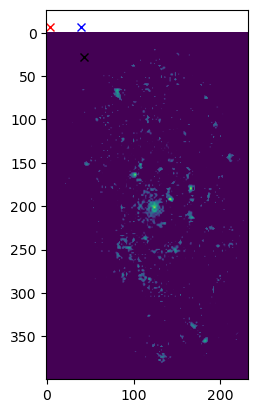

In [49]:
# Sum columns

log_n = Astropy_Table['log_n'].sum()
log_re = Astropy_Table['log_re'].sum()
mag = Astropy_Table['mag'].sum()
q = Astropy_Table['q'].sum()
theta = Astropy_Table['theta'].sum()
x = Astropy_Table['x'].sum()
y = Astropy_Table['y'].sum()

# Want to plot (x,y) position on image to check:
Img = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ua/0135/small_nonpar.fits')

plt.figure()
plt.imshow(Img)
plt.plot(x,y,'xk')
plt.plot(Astropy_Table['x'][0],Astropy_Table['y'][0],'xr')
plt.plot(Astropy_Table['x'][1],Astropy_Table['y'][0],'xb')


# Something wrong here, have emailed steven

In [50]:
Composite_isolated[:,:,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
Composite[:,:,1]
# Clearly need to take off the background

array([[1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       ...,
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.],
       [1000., 1000., 1000., ..., 1000., 1000., 1000.]])

In [52]:
Composite[:,:,1] - 1000

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

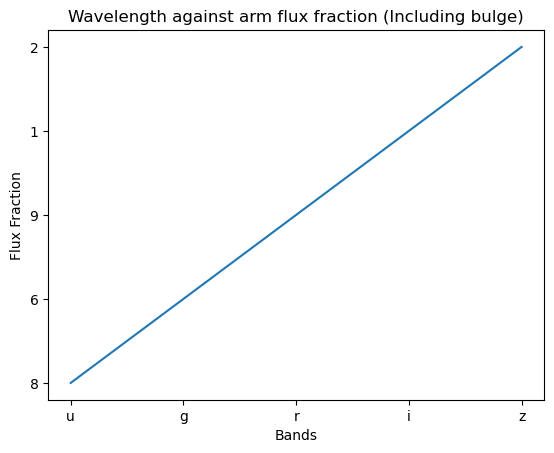

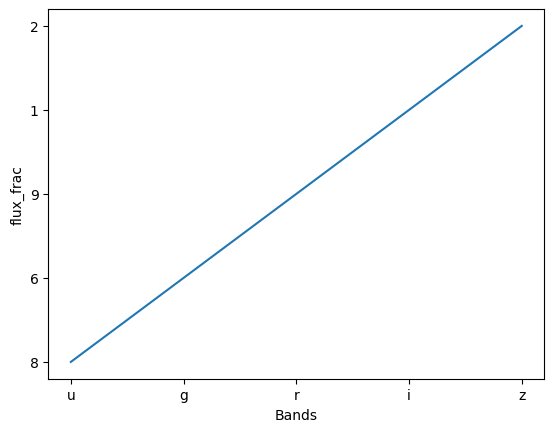

In [53]:
# Wish to make a flux fraction graph and generalise into a function


def flux_frac(Composite,Composite_isolated):
    """
    Calculates the flux fraction between a composite image and an isolated composite image for each band.

    Args:
    - Composite (np.ndarray): A 3D numpy array of the composite image.
    - Composite_isolated (np.ndarray): A 3D numpy array of the isolated composite image.

    Returns:
    - np.ndarray: A 1D numpy array containing the flux fraction for each band.
    """
    background = 1000
    flux_fraction = np.zeros_like(bands)

    for i in range(0,len(bands)):
        flux_fraction[i] = float(np.sum(Composite[:,:,i]-background)-np.sum(Composite_isolated[:,:,i]))
        
    return(flux_fraction)


fluxes = flux_frac(Composite=Composite,Composite_isolated=Composite_isolated)
plt.figure()
plt.plot(bands,fluxes)
plt.xlabel('Bands')
plt.ylabel('Flux Fraction')
plt.title('Wavelength against arm flux fraction (Including bulge)')

# Very linear
# Will now make a plot against bands function to save time in future

def plot_against_bands(array,y_label):
    plt.figure()
    plt.xlabel('Bands')
    plt.ylabel(y_label)
    plt.plot(bands,array)
    
plot_against_bands(fluxes,'flux_frac')

In [54]:
# want a function which converts flux to magnitude using filename and flux_20

filename = '588017724937142430ra.fits.gz'

# create function for removing file information
def remove_file_info(filename):
    n = len('.fits.gz')
    file = filename[:-n]
    return file

def remove_band_info(filename):
    n = len('ra.fits.gz')
    file = filename[:-n]
    return file

test = remove_file_info(filename)
#print(test)

test = remove_band_info(filename)
#print(test)

# remove file info
file = remove_band_info(filename)

# locate in catalogue
mask = good_spiral_data['OBJID_STR'] == file
row = good_spiral_data[mask]
print(row)

[(588017724937142430, '588017724937142430', 3841, 41, 3, 131, 158, 184.49215698, 7.18591261, 19.952961, 42.790424, 15.454557, 13.61601, 12.971089, 12.67899, 12.709483, 0.06758226, 0.01395545, 0.00284802, 0.01338871, 0.03700842, 18.544622, 17.754324, 13.423666, 0.0023005, 12.95515, 0.00205375, 0.1666219, 21.46657562, 0.12459493, 0.09167577, 0.06649091, 0.05041805, 0.03574702, 758.6068, 1050.3589, 763.6434, 1049.8337, 753.2675, 1048.6578, 756.5022, 1047.7573, 760.9121, 1048.2147, 13.02048016, 0.00183683, 0.0124047, 0.00016187, -18.397, -20.151169, -20.73143, -21.02223, -20.946833, 0.07047952, 0.01716842, 0.01039765, 0.01671101, 0.03833567, 5.0619745, 2, 50, 65, 0, 15, 'original', 221797, 315, 314.079, 1., 0.025, 39., 0.973, 0.079, 0.002, 40.079, 1., 0.026, 38., 0.974, 39., 2., 0.053, 36., 0.947, 38., 38., 1., 0., 0., 38., 4., 0.105, 24., 0.632, 10., 0.263, 0., 0., 38., 3., 0.075, 37., 0.925, 40., 1., 1., 0., 0., 0., 0., 1., 1., 0.333, 0., 0., 0., 0., 0., 0., 2., 0.667, 0., 0., 0., 0., 3.

In [55]:
good_spiral_data['COLC_R']

array([ 698.9163 ,  897.0576 ,  339.5624 ,  935.11285, 1726.197  ,
       1611.0154 , 1048.6578 , 1796.6527 ], dtype=float32)

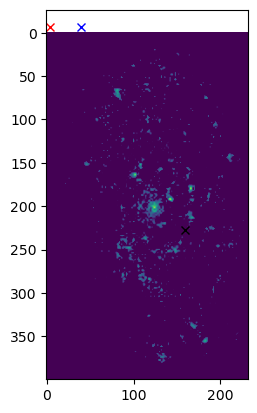

In [56]:
# Sum columns

log_n = Astropy_Table['log_n'].sum()
log_re = Astropy_Table['log_re'].sum()
mag = Astropy_Table['mag'].sum()
q = Astropy_Table['q'].sum()
theta = Astropy_Table['theta'].sum()
x = Astropy_Table['x'].sum()
y = Astropy_Table['y'].sum()

# Want to plot (x,y) position on image to check:
Img = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ua/0135/small_nonpar.fits')

plt.figure()
plt.imshow(Img)
plt.plot(Img.shape[1]/2 + x, Img.shape[0]/2 + y,'xk')
plt.plot(Astropy_Table['x'][0],Astropy_Table['y'][0],'xr')
plt.plot(Astropy_Table['x'][1],Astropy_Table['y'][0],'xb')


# Something wrong here, have emailed steven

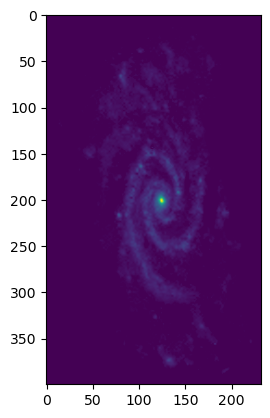

In [57]:
# Should create a function which collects the output files for processing into composites

# get current working directory to return to at the end
current = os.getcwd()

folder_location = '/home/borge/Data/Output_Data/588017724937142430ga'

Parent_directory = '/home/borge/Data/Output_Data'
ID = str(587726031719301138)
bands_suffix = np.array(['ua','ga','ra','ia','za'])

directrories_to_raid = []

for i in range(0,len(bands)):
    directory = Parent_directory + ID + bands_suffix[i]
    directrories_to_raid.append(directory)


# Move to folder 
os.chdir(folder_location)

# List directory contents
contents = os.listdir()
# convert to an array
arr = np.asarray(contents).astype(int)

# Find contents largest output value
latest = np.max(arr)

# Convert back to string     (we assume no iterations over 1000)
latest = '0' + str(latest)

# Move to most recent output directory
os.chdir(latest)

# Read files in
source_params_table = gfits.Read_Table('source_params.fits')
small_non_par_image = gfits.Read('small_nonpar.fits')


plt.imshow(small_non_par_image)
os.listdir()
source_params_table

os.chdir(current)

In [58]:
def raid_directory(directory_path):
    """
    Navigates to the most recent subdirectory within a given directory path and reads in two FITS files.

    Parameters:
    -----------
    directory_path : str
        A string representing the path of the directory to search for subdirectories.

    Returns:
    --------
    Tuple
        A tuple of two FITS file objects, `source_params_table` and `small_non_par_image`.

    Raises:
    -------
    FileNotFoundError:
        If no subdirectories are found within the given directory.
    TypeError:
        If the directory path provided is not a string.

    Note:
    -----
    This function assumes that the subdirectories within the given directory have integer names and that the most recent subdirectory has the highest integer value name. Additionally, it assumes that the FITS files `source_params.fits` and `small_nonpar.fits` exist within the most recent subdirectory.
    """
    # get current working directory to return to at the end
    current = os.getcwd()
    
    # Move to folder 
    os.chdir(directory_path)

    # List directory contents
    contents = os.listdir()
    # convert to an array
    arr = np.asarray(contents).astype(int)

    # Find contents largest output value
    latest = np.max(arr)

    # Convert back to string     (we assume no iterations over 1000)
    latest = '0' + str(latest)

    # Move to most recent output directory
    os.chdir(latest)

    # Read files in
    source_params_table = gfits.Read_Table('source_params.fits')
    small_non_par_image = gfits.Read('small_nonpar.fits')
    
    # Return to original directory
    os.chdir(current)
    return(source_params_table,small_non_par_image)

In [59]:
source_table, small_nonpar_image = raid_directory('/home/borge/Data/Output_Data/588017724937142430ga')
os.getcwd() 
# Working

'/home/borge/ficl'

In [60]:
# Now need a way of running through the directories but want to do it 
# such that each band is done one after another and read into a composite array


Parent_directory = '/home/borge/Data/Output_Data/'
ID = str(588017724937142430)
bands_suffix = np.array(['ua','ga','ra','ia','za'])

directrories_to_raid = []

for i in range(0,len(bands)):
    directory = Parent_directory + ID + bands_suffix[i]
    directrories_to_raid.append(directory)
    
# creates a list of directories based on the OBJID    
directrories_to_raid


['/home/borge/Data/Output_Data/588017724937142430ua',
 '/home/borge/Data/Output_Data/588017724937142430ga',
 '/home/borge/Data/Output_Data/588017724937142430ra',
 '/home/borge/Data/Output_Data/588017724937142430ia',
 '/home/borge/Data/Output_Data/588017724937142430za']

In [61]:
# Now need a function which will run through this list
# and write the outputs to composites for analysis
# Require a function that will sample the image size to create the composite to fill

source0, nonpar0 = raid_directory(directrories_to_raid[0])
Composite_Source_Table = source0[0]
Isolated_Composite = np.empty((nonpar0.shape[0],nonpar0.shape[1],len(bands)))
Isolated_Composite[:,:,0] = nonpar0

for i in range(1,len(bands)):
    source_table, non_par = raid_directory(directrories_to_raid[i])
    Isolated_Composite[:,:,i] = non_par
    Composite_Source_Table = np.vstack([Composite_Source_Table,source_table[0]])

In [62]:
Table(Composite_Source_Table)

# Boom so this works

log_n,log_re,mag,q,theta,x,y
float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1]
-0.6705718645323709,1.9057735764247934,-11.689559321743083,0.3920720032116352,1.5257237595672486,4.0132007406991095,-6.273547050102553
-0.2290653837309824,1.9021695777751866,-14.538873508877499,0.37501364508599877,1.4310862333561503,9.774442279177787,-5.091164382567836
-0.20920804668234907,1.8714935044597412,-14.923551195645546,0.3963925481036036,1.4213024836580053,8.994719160292219,-5.092082480356812
-0.20010365646596737,1.880364694936267,-15.05025602053592,0.4239073447916598,1.4620009942487198,8.909881999582021,-4.213315029646895
-0.2922423794732836,1.824654910501865,-13.286667343210462,0.462018440133129,1.466191410501114,9.338820888023719,-3.3624511270045354


In [63]:
# Combine this into a function

def Composite_from_directory_raid(OBJID,Parent_directory):
    """
    Create a composite image and source parameter table by raiding multiple directories.

    Parameters
    ----------
    OBJID : str
        The object ID used to create directory names.
    Parent_directory : str
        The parent directory where the OBJID subdirectories are located.

    Returns
    -------
    Composite_Source_Table : astropy.table.Table
        A table containing the composite source parameters.
    Isolated_Composite : numpy.ndarray
        A 3D array containing the isolated composite image data.

    Notes
    -----
    The function expects the OBJID subdirectories to have the following suffixes:
    'ua', 'ga', 'ra', 'ia', 'za', corresponding to the five filter bands used in the imaging survey.
    The function first raids the directory for the first filter band to get the image dimensions,
    and then reads in the non-parametric images from the other bands to create the isolated composite.
    The source parameter tables from all bands are stacked together to create the composite source parameter table.
    Finally, the composite source parameter table is augmented with additional columns indicating the filter band and
    the corresponding effective wavelength.
    """
    # Create suffix array for raiding
    bands_suffix = np.array(['ua','ga','ra','ia','za'])

    # Initialise list of directories to raid
    directrories_to_raid = []

    # creates a list of directories based on the OBJID    
    directrories_to_raid
    for i in range(0,len(bands)):
        directory = Parent_directory + OBJID + bands_suffix[i]
        directrories_to_raid.append(directory)
         
    # First raid directory to get image dimensions for Composite
    source0, nonpar0 = raid_directory(directrories_to_raid[0])
    Composite_Source_array = source0[0]
    Isolated_Composite = np.empty((nonpar0.shape[0],nonpar0.shape[1],len(bands)))
    Isolated_Composite[:,:,0] = nonpar0

    # Raid the rest of the directories
    for i in range(1,len(bands)):
        source_table, non_par = raid_directory(directrories_to_raid[i])
        Isolated_Composite[:,:,i] = non_par
        Composite_Source_array = np.vstack([Composite_Source_array,source_table[0]])
    
    # Convert array to astropy table
    Composite_Source_Table = Table(Composite_Source_array)
    
    # Now want to add a column detailing band and corresponding central wavelength
    Composite_Source_Table.add_column(bands, name='Band')
    Composite_Source_Table.add_column(wavs,name='Effective Wavelength')
        
    return Composite_Source_Table, Isolated_Composite

In [64]:
tab,comp = Composite_from_directory_raid('588017724937142430','/home/borge/Data/Output_Data/')

In [65]:
tab

log_n,log_re,mag,q,theta,x,y,Band,Effective Wavelength
float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],str1,float64
-0.6705718645323709,1.9057735764247934,-11.689559321743083,0.3920720032116352,1.5257237595672486,4.0132007406991095,-6.273547050102553,u,3.543e-07
-0.2290653837309824,1.9021695777751866,-14.538873508877499,0.37501364508599877,1.4310862333561503,9.774442279177787,-5.091164382567836,g,4.77e-07
-0.20920804668234907,1.8714935044597412,-14.923551195645546,0.3963925481036036,1.4213024836580053,8.994719160292219,-5.092082480356812,r,6.231e-07
-0.20010365646596737,1.880364694936267,-15.05025602053592,0.4239073447916598,1.4620009942487198,8.909881999582021,-4.213315029646895,i,7.625e-07
-0.2922423794732836,1.824654910501865,-13.286667343210462,0.462018440133129,1.466191410501114,9.338820888023719,-3.3624511270045354,z,9.134e-07


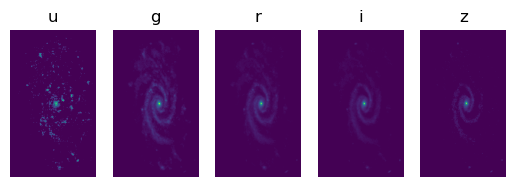

In [66]:
gfits.Composite_imshow(comp)

# Woo this works too!

In [67]:
# home made and slow
def gini_coefficient(image):
    """Compute Gini coefficient of array of values"""
    x = img.flatten()
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))


In [68]:
%timeit  
a = gini_coefficient(Composite[:,:,1])
print(a)


0.008641477236752194


In [69]:
# From http://rb.gy/s3ijjr and much faster!
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [70]:
a = gini(Composite[:,:,1])
print(a)
%timeit 

0.008641477235897777


Want a function that will take a composite and an image function and return the function acting on each band of the composite


- This will only work if the composite returned has shape:
-  `(img.shape[0],img.shape[1].len(bands))`

In [71]:
def Img_2_Comp(Composite_array,function):
    Composite_output = np.empty_like(Composite_array)
    for i in range(0,len(bands)):
        Composite_output[:,:,i] = function(Composite_array[:,:,i])
    
    return Composite_output

def func_on_Comp(Composite_array,function):
    out = np.empty(len(bands))
    for i in range(0,len(bands)):
        out[i] = function(Composite_array[:,:,i])
    return out


# Quite pleased with these, have never used function objects as input

In [72]:
a = func_on_Comp(Composite,gini)
a

array([0.00235861, 0.00864148, 0.01150165, 0.01209186, 0.0034523 ])

In [73]:
a = func_on_Comp(Composite_isolated,gini)
a

array([0.97489948, 0.84297101, 0.86580508, 0.89777501, 0.96056323])

Now need a function to measure the concentration asymmetry of an image

In [74]:
from scipy.stats import circmean


def asymmetry(image,x,y):
    """
    Calculates the concentration asymmetry of an image array.

    Parameters
    ----------
    image : 2D numpy array
        The input image array.

    Returns
    -------
    asymmetry_measure : float
        The concentration asymmetry of the image, ranging from 0 (perfectly symmetric)
        to 1 (completely asymmetric).
    """
    # Define the center position of the image
    center = ((image.shape[0] // 2)+x, (image.shape[1] // 2)+y)

    # Define the left and right halves of the image based on the center position
    half_size = min(center[1], image.shape[1] - center[1])
    left_half = image[:, center[1] - half_size:center[1]]
    right_half = image[:, center[1]:center[1] + half_size]

    # Concatenate the left and right halves into a single array
    asymmetry_array = np.concatenate((left_half, right_half), axis=1)

    # Calculate the concentration asymmetry of the array
    asymmetry_measure = np.abs(circmean(asymmetry_array[:, 0]) - circmean(asymmetry_array[:, -1]))

    return asymmetry_measure


In [75]:
print(tab['x'][0])

print( int(np.round(tab['x'][0])))

[4.01320074]
4


In [76]:
x = int(np.round(tab['x'][3]))
y = int(np.round(tab['y'][3]))
a = asymmetry(comp[:,:,3],x,y)
a

6.279373867409209

In [77]:
files = ['small_nonpar.fits']
loc = '/home/borge/Data/Output_Data/588017724937142430ra/0200'
config_p = '/home/borge/Data/Config_files'
out_p = '/home/borge/Data/Second_run'
#gfits.command_line_file_list_run(files,loc,config_p,out_p)

In [78]:
# So it doesnt work right now if you run it a second time

In [79]:
from skimage.transform import hough_line

def hough_transform(image):
    """
    Apply the Hough transform to an image to detect lines.

    Parameters
    ----------
    image : ndarray
        Input image.
    theta_range : tuple or None, optional
        Range of theta values to use, specified as a tuple (min_theta, max_theta). 
        If not specified, the range (-pi/2, pi/2) is used.

    Returns
    -------
    rhos : ndarray
        Distance values for each row in the Hough transform accumulator.
    thetas : ndarray
        Angle values for each column in the Hough transform accumulator.
    accumulator : ndarray
        Hough transform accumulator array.
    """
    h, w = image.shape
    diag_len = np.sqrt((h-1)**2 + (w-1)**2)
    num_rhos = int(2 * diag_len)
    rhos = np.linspace(-diag_len, diag_len, num=num_rhos)
    hough, thetas, rhos = hough_line(image)
    return rhos, np.rad2deg(thetas), hough

# Final edition

In [80]:
# This is good but we need to detect spiral structure so require logarithmic version
from skimage.transform import hough_line

def hough_transform(image):
    """
    Apply the Hough transform to an image to detect lines.

    Parameters
    ----------
    image : ndarray
        Input image.
    theta_range : tuple or None, optional
        Range of theta values to use, specified as a tuple (min_theta, max_theta). 
        If not specified, the range (-pi/2, pi/2) is used.

    Returns
    -------
    rhos : ndarray
        Distance values for each row in the Hough transform accumulator.
    thetas : ndarray
        Angle values for each column in the Hough transform accumulator.
    accumulator : ndarray
        Hough transform accumulator array.
    """
    h, w = image.shape
    diag_len = np.sqrt((h-1)**2 + (w-1)**2)
    num_rhos = int(2 * diag_len)
    rhos = np.linspace(-diag_len, diag_len, num=num_rhos)
    hough, thetas, rhos = hough_line(image)
    return rhos, np.rad2deg(thetas), hough

# Final edition

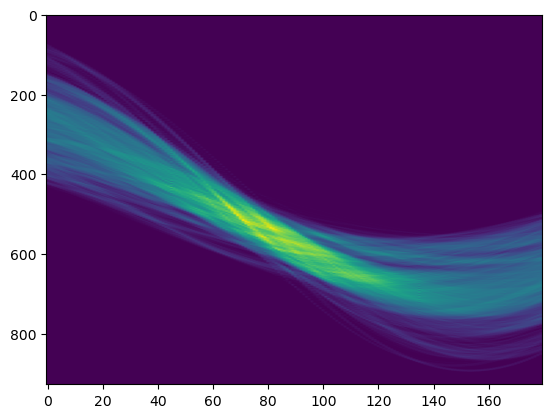

In [81]:
from skimage.transform import hough_ellipse
Image = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ia/0188/small_nonpar.fits')
#accumulator, yc, xc, a, b, orientation = hough_ellipse(Image)
from skimage.transform import hough_line
hough, t, r = hough_line(Image)
plt.imshow(hough,aspect='auto')

        x        
-----------------
9.774442279177787
        y         
------------------
-5.091164382567836


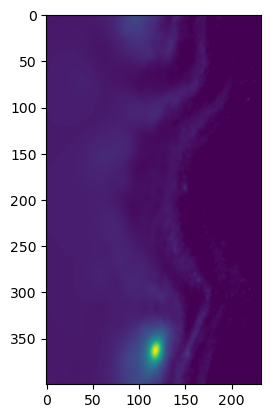

In [82]:
from skimage.transform import warp_polar

Batch_im = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ga/0200/small_nonpar.fits')
Batch_T  = gfits.Read_Table('/home/borge/Data/Output_Data/588017724937142430ga/0200/source_params.fits')

x,y = Batch_T['x'],Batch_T['y']
print(x)
print(y)
C = (Batch_im.shape[0]/2 + x, Batch_im.shape[1]/2 + y)

warp = warp_polar(Image, center=C,scaling='log',output_shape=Image.shape)
plt.imshow(warp)


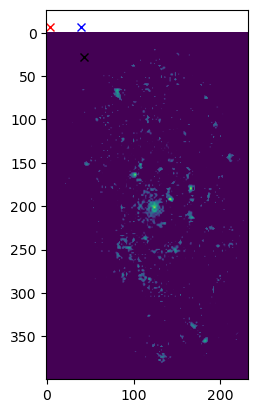

In [83]:
# Sum columns

log_n = Astropy_Table['log_n'].sum()
log_re = Astropy_Table['log_re'].sum()
mag = Astropy_Table['mag'].sum()
q = Astropy_Table['q'].sum()
theta = Astropy_Table['theta'].sum()
x = Astropy_Table['x'].sum()
y = Astropy_Table['y'].sum()

# Want to plot (x,y) position on image to check:
Img = gfits.Read('/home/borge/Data/Output_Data/588017724937142430ua/0135/small_nonpar.fits')

plt.figure()
plt.imshow(Img)
plt.plot(x,y,'xk')
plt.plot(Astropy_Table['x'][0],Astropy_Table['y'][0],'xr')
plt.plot(Astropy_Table['x'][1],Astropy_Table['y'][0],'xb')


# Something wrong here, have emailed steven

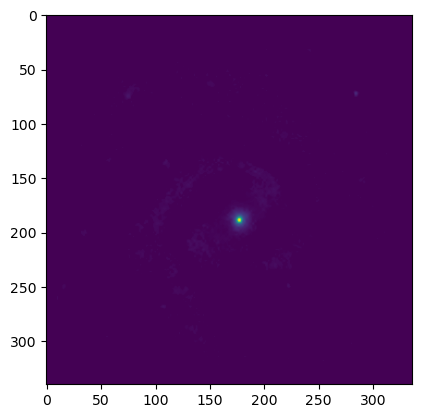

In [84]:
b = gfits.Read('/home/borge/Data/MLIS1_Output/Output/587731892188545037za/0200/small_nonpar.fits')
plt.imshow(b)

In [85]:
import os
import shutil
import jax
import numpy as np
from jax import numpy as jnp
from astropy.table import Table, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import gax_fits as gfits
bands = np.array(['u','g','r','i','z'])


#files = np.loadtxt('Folder_list.txt',dtype=str)

name = input("type your name: ")

if name == 'aden' or 'Aden':
    mask = (0,10)
elif name == 'shivani' or 'Shivani':
    mask = (30,40)
else:
    print('No')
#out = input("paste path to output folder: ")
#data = input("paste path to data folder: ")
#config = input("paste path to config folder: ")

#a = files[mask[0]:mask[1]]
#print(a)
#gfits.command_line_file_list_run(file_list=a,data_location=data,config_path=config,output_path=out)
#print("config files in: ",config,"output files in:",out,"data in: ",data)

In [86]:
a = ['587732050555961424ua.fits.gz']
out = '/home/borge/Data/Output_Data/Distributed_run'
data = '/home/borge/Data/Test_batch'
config = '/home/borge/Data/Config_files'


In [87]:
#gfits.command_line_file_list_run(file_list=a,data_location=data,config_path=config,output_path=out)


In [88]:
Table_587726031719301138, Composite_587726031719301138 = gfits.Composite_from_directory_raid('587726031719301138','/home/borge/Data/Output_Data/Distributed_run/')
Table_587731892188545037, Composite_587731892188545037 = gfits.Composite_from_directory_raid('587731892188545037','/home/borge/Data/Output_Data/Distributed_run/')
Table_588848900983357543, Composite_588848900983357543 = gfits.Composite_from_directory_raid('588848900983357543','/home/borge/Data/Output_Data/Distributed_run/')


In [89]:
gini_C587726031719301138 = func_on_Comp(Composite_587726031719301138,gini)
gini_C587731892188545037 = func_on_Comp(Composite_587731892188545037,gini)
gini_C588848900983357543 = func_on_Comp(Composite_588848900983357543,gini)

ginis = np.stack([gini_C587731892188545037,gini_C587726031719301138,gini_C588848900983357543]).T

In [90]:
gini_C587726031719301138 = func_on_Comp(Composite_587726031719301138,gini)
gini_C5587731892188545037 = func_on_Comp(Composite_587731892188545037,gini)
gini_C588848900983357543 = func_on_Comp(Composite_588848900983357543,gini)

ginis = np.stack([gini_C587731892188545037,gini_C587726031719301138,gini_C588848900983357543])
print(ginis)

[[0.91690131 0.8528163  0.87621292 0.8751823  0.97586266]
 [0.89685537 0.80908229 0.81461642 0.80906552 0.90165596]
 [0.81138368 0.85183687 0.88583865 0.89626285 0.91756229]]


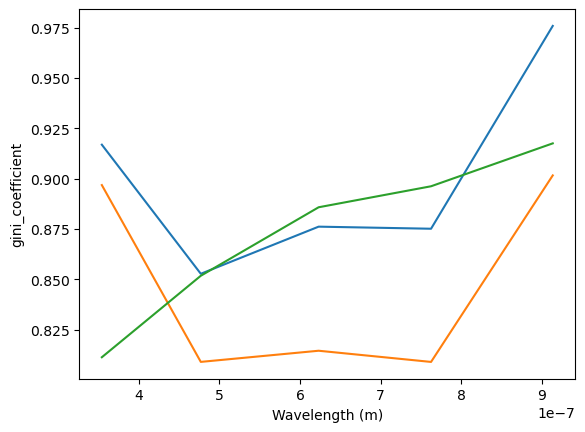

In [91]:
plt.figure()
plt.xlabel('Wavelength (m)')
plt.ylabel('gini_coefficient')
plt.plot(wavs,ginis.T)

In [92]:

flux_frac_C587726031719301138 = flux_frac(gfits.Read_M_band('587726031719301138','/home/borge/Data/Test_batch/'),Composite_587726031719301138)
flux_frac_C587731892188545037 = flux_frac(gfits.Read_M_band('587731892188545037','/home/borge/Data/Test_batch/'),Composite_587731892188545037)
flux_frac_C588848900983357543 = flux_frac(gfits.Read_M_band('588848900983357543','/home/borge/Data/Test_batch/'),Composite_588848900983357543)

flux_fracs = np.stack([flux_frac_C587731892188545037,flux_frac_C587726031719301138,flux_frac_C588848900983357543])
print(flux_fracs)

['/home/borge/Data/Test_batch/587726031719301138ua.fits.gz']
['/home/borge/Data/Test_batch/587726031719301138ga.fits.gz']
['/home/borge/Data/Test_batch/587726031719301138ra.fits.gz']
['/home/borge/Data/Test_batch/587726031719301138ia.fits.gz']
['/home/borge/Data/Test_batch/587726031719301138za.fits.gz']
['/home/borge/Data/Test_batch/587731892188545037ua.fits.gz']
['/home/borge/Data/Test_batch/587731892188545037ga.fits.gz']
['/home/borge/Data/Test_batch/587731892188545037ra.fits.gz']
['/home/borge/Data/Test_batch/587731892188545037ia.fits.gz']
['/home/borge/Data/Test_batch/587731892188545037za.fits.gz']
['/home/borge/Data/Test_batch/588848900983357543ua.fits.gz']
['/home/borge/Data/Test_batch/588848900983357543ga.fits.gz']
['/home/borge/Data/Test_batch/588848900983357543ra.fits.gz']
['/home/borge/Data/Test_batch/588848900983357543ia.fits.gz']
['/home/borge/Data/Test_batch/588848900983357543za.fits.gz']
[['5' '9' '1' '1' '4']
 ['1' '7' '1' '1' '3']
 ['-' '6' '9' '9' '2']]


In [93]:
#lt.figure()
#plt.xlabel('Fraction of flux in spiral arms')
#plt.ylabel('gini_coefficient')
#plt.plot(wavs,flux_fracs)#

In [98]:
# Get composite image and corresponding centers
Images = Composite_587726031719301138
Image = Composite_587726031719301138[:,:,1]
centers = np.stack([np.asarray(Table_587726031719301138['x']) + (Image.shape[1]/2), np.asarray(Table_587726031719301138['y'])+ (Image.shape[0]/2)])
axis_ratios = np.asarray(Table_587726031719301138['q'])
R_min = 0.1*(10**(Table_587726031719301138['log_re']))
print(R_min)
# Need a way of going between linear eccentricity 'q'
# To b and a q = sqrt(b^2 +a^2) 

# Need way to convert from position in the array in terms of difference to the center

# First collect all the indicese
Image = Image + 0.1
Indicese = np.nonzero(Image)
Image = Image - 0.1

# Seems like the easiest way to do it

A = 360 # Number of degrees to perform transform over
R = int(np.ceil(np.hypot(*Image.shape)))

def simple_acc_transform(Image,x,y):
    Accumulator = np.empty((R,A))

    # Distance to the center
    for i in range(0,Image.shape[0]):
        for j in range(0,Image.shape[1]):
            dx = j - x
            dy = i - y
            r = np.hypot(dx, dy)
            theta = np.arctan2(dy, dx)
            
            r_idx = int(r)
            theta_idx = int(theta * A / (2 * np.pi))
            
            
            Accumulator[r_idx, theta_idx] = Image[i, j]
    return Accumulator
        
Accumulator = simple_acc_transform(Image,Image.shape[1]/2 + x[1] -2,Image.shape[0]/2 + y[1]- 4)


      log_re      
------------------
0.5755345767785032
 6.930925213125673
 8.049193541781598
 6.759509634070335
 4.743149251161242


IndexError: invalid index to scalar variable.

In [ ]:
#plt.imshow(Accumulator)

In [ ]:
transformed_image = np.zeros_like(Image)
for r_idx in range(R):
    for theta_idx in range(A):
        i = int(centers[0][0] + r_idx * np.sin(theta_idx * 2 * np.pi / A))
        j = int(centers[0][1] + r_idx * np.cos(theta_idx * 2 * np.pi / A))
        if i >= 0 and i < Image.shape[0] and j >= 0 and j < Image.shape[1]:
            transformed_image[i, j] = Accumulator[r_idx, theta_idx]

NameError: name 'Accumulator' is not defined

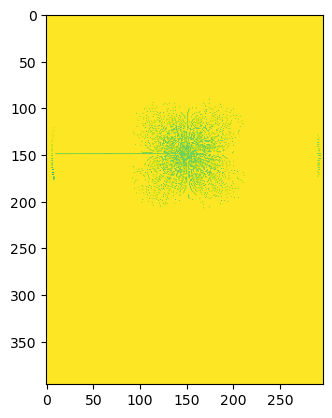

In [ ]:
plt.imshow(transformed_image)

In [ ]:
print(centers)
print(centers[0,0])
print(centers[1,0])

x = Table_587726031719301138['x']
y = Table_587726031719301138['y']

[[[149.31316751]
  [151.10961695]
  [149.95737546]
  [149.97691087]
  [150.04382107]]

 [[189.40508636]
  [191.97152206]
  [190.19433947]
  [189.31419344]
  [188.57349452]]]
[149.31316751]
[189.40508636]


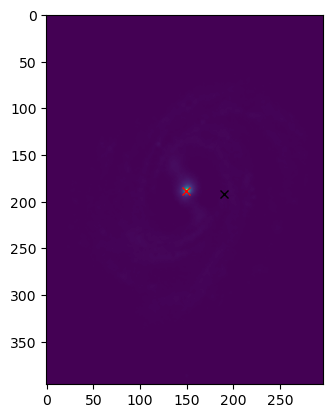

In [ ]:
plt.imshow(Image)
plt.plot(Image.shape[1]/2 + x[1] -2,Image.shape[0]/2 + y[1]- 4,'xr')
plt.plot(centers[1,0],centers[1,1],'xk')

In [ ]:
x = Table_587726031719301138['x']
y = Table_587726031719301138['y']
print(x)
print(y)

        x         
------------------
1.3131675072627844
3.1096169517776087
1.9573754604592057
1.9769108708882057
 2.043821068748152
         y         
-------------------
 -8.594913642228141
-6.0284779426093476
 -7.805660534401525
 -8.685806555727915
 -9.426505484389402


In [99]:
#mod_center = np.array([Image.shape[1]/2 + x[1] -2,Image.shape[0]/2 + y[1]- 4])
#acc  = simple_acc_transform(Image,mod_center[0],mod_center[1])
#plt.imshow(acc)
#acc

In [100]:
# contains some nans so interpolate the nans?

bad_indices = np.isnan(acc)
bad_indices

NameError: name 'acc' is not defined

In [ ]:
from astropy.convolution import interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel

kernel = kernel = Gaussian2DKernel(x_stddev=4)
int_acc = interpolate_replace_nans(acc,kernel)


/home/borge/anaconda3/envs/ficl/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/borge/anaconda3/envs/ficl/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


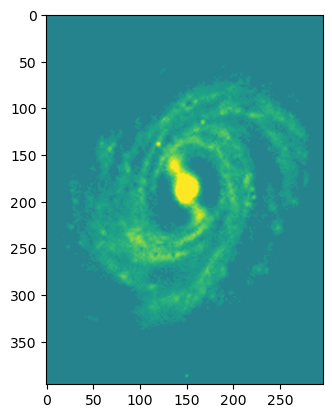

In [ ]:
plt.figure()
plt.imshow(Image)
plt.clim(np.mean(Image) - 2*np.std(Image),np.mean(Image) + 2*np.std(Image))


/home/borge/anaconda3/envs/ficl/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/borge/anaconda3/envs/ficl/lib/python3.10/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/tmp/ipykernel_414/2614252063.py:5: RuntimeWarning: invalid value encountered in scalar add
  plt.clim(np.mean(acc) - 2*np.std(acc),np.mean(acc) + 2*np.std(acc))


array([[1.00000000e+00, 2.60832109e+03, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.42235727e+03, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.83985844e+03, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [9.22956431e-01, 8.01196602e+00, 1.41875267e+01, ...,
        0.00000000e+00, 4.52471582e-14, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.13229415e+01, 1.41669585e+01, 1.43646740e+01],
       [1.49565375e+01, 1.79843955e+01, 1.98771658e+01, ...,
        4.52471582e-14, 0.00000000e+00, 0.00000000e+00]])

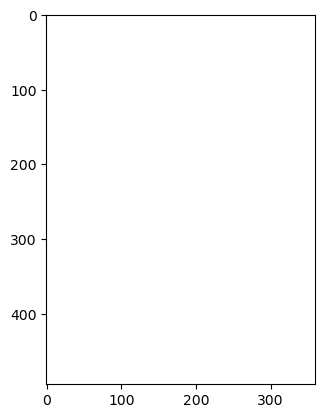

In [ ]:
acc = np.nan_to_num(acc,nan=1)

plt.figure()
plt.imshow(acc)
plt.clim(np.mean(acc) - 2*np.std(acc),np.mean(acc) + 2*np.std(acc))

acc

In [ ]:
failure = gfits.Read('/home/borge/Data/Test_batch/587732050555961424ua.fits.gz')
plt.imshow(failure)

NameError: name 'gfits' is not defined